In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scripts.result_parser import get_df
%matplotlib inline

In [2]:
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(context='notebook', style='darkgrid', font='serif')
sns.set_palette(flatui, n_colors=3)
#plt.style.use('seaborn-notebook')
params = {'font.family': 'serif',
          'legend.fontsize': 6,
          'legend.handlelength': 2,
          'figure.dpi': 300,
          'lines.markersize': 4,
          'axes.titlesize': 8,
          'axes.labelsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8}
plt.rcParams.update(params)

> load results

In [9]:
direct_sphere_df = get_df('runs/sphere_convergence/direct/', formulation='direct', skip4=True)
juffer_sphere_df = get_df('runs/sphere_convergence/juffer/', formulation='juffer', skip4=True)

> Compute relative error with respect to the analytical solution.

In [4]:
e_solv_exact = -12.2583630
e_solv = direct_sphere_df['e_solv [kcal/Mol]'].values
rel_error_direct = np.abs((e_solv-e_solv_exact)/e_solv_exact)
e_solv = juffer_sphere_df['e_solv [kcal/Mol]'].values
rel_error_juffer = np.abs((e_solv-e_solv_exact)/e_solv_exact)
e_solv_collocation = np.array((-12.4326706, -12.301547, -12.269150778, -12.261115, -12.25916835))
rel_error_collocation = np.abs((e_solv_collocation-e_solv_exact)/e_solv_exact)

Before each result section, mention the hardware and explain the difference between direct and Juffer's formulation (maybe in method section).

#### hardware:
- `defq`: 2 * Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz, 20 cores/socket, 192GB DRAM

## Mesh refinement study using a spherical molecule and an off-center charge

To verify our BEM-FMM integration, we first performed a mesh refinement study for a spherical molecule with an off-center charge.
Figure ? depicts the problem setup.
The molecule has a radius of $4A$ and a relative permittivity of $\epsilon_1 = 4$; the unit charge is located at $(1,1,1)$.
The solvent region has a relative permittivity of water ($\epsilon_2 = 80$); and the salt concentration is set to $150mM$ $(\kappa = 1/8A^{-1})$.
Other parameters are listed in Table ?.
We compute the solvation energy of this molecule using 5 meshes with a constant refinement factor of 4.

#### Table: simulation parameters for the mesh refinement study for a spherical molecule
| tolerance | regular quadrature order | FMM expansion order | FMM ncrit |
|:---------:|:------------------------:|:-------------------:|:---------:|
|    1e-7   |             4            |          10         |    500    |

Kirkwood's derivation allows us to compute the analytical solution of the solvation energy for this spherical molecule: $-12.2583630$ [kCal/mol],
with which we can compare our results. Figure ? shows the error of the solvation energy converges at the expected rate of $1/N$ for both formulations.




#### Figure: Mesh convergence study of the solvation energy of a spherical molecule with an off-center charge, using both direct formulation and Juffer's formulation. The error is with respect to the analytical solution $-12.2583630$ [kCal/mol]. The sphere is discretized with 512, 2048, 8192, 32768 and 131072 boundary elements.

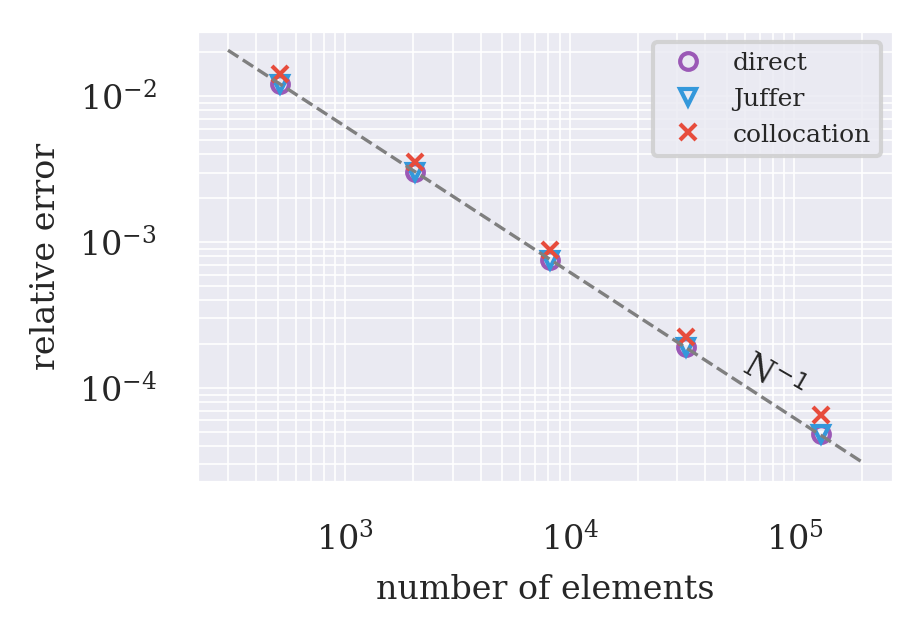

In [5]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
N = direct_sphere_df.index.values
N_ = np.array((3e2, 2e5))
asymp = N[2] * rel_error_direct[2] / N_
ax.loglog(N, rel_error_direct, linestyle='', marker='o', fillstyle='none', label='direct', ms=4)
ax.loglog(N, rel_error_juffer, linestyle='', marker='v', fillstyle='none', label='Juffer', ms=4)

ax.loglog(N, rel_error_collocation, linestyle='', marker='x', label='collocation', ms=4)

ax.loglog(N_, asymp, linestyle='--', color='#7f7f7f', linewidth=0.8)
ax.grid(which="both", lw=0.4)
ax.set_xlabel('number of elements')
ax.set_ylabel('relative error')
ax.legend()

loc = (3*N[-2]+N[-1])/4
text_loc = np.array((loc, 1.2*N[-2]*rel_error_direct[-2]/loc))
ax.text(text_loc[0], text_loc[1],r'N$^{-1}$', fontsize=8, rotation=-30,rotation_mode='anchor');

--------


### Appendix


1. additional simulation parameter: `restart=400` (interface from `scipy.sparse.linalg.gmres`, make sure we use full GMRES instead of restarted GMRES)
2. Juffer and co-workers developed a formulation that is better-conditioned than direct formulation

- direct formulation: piecewise constant element, block-diagonal preconditioner (4 Laplace FMMs + 4 modified Helmholtz FMMs)

$$
\begin{bmatrix}
    \tfrac12\mathrm{I} + \mathrm{K}_L &  -\mathrm{V}_L \\
    \tfrac12\mathrm{I} - \mathrm{K}_H &  \frac{\epsilon_1}{\epsilon_2}\mathrm{V}_H
\end{bmatrix}
\left\{
\begin{matrix}
    \phi \\
    \frac{\partial \phi}{\partial \mathbf{n}}
\end{matrix}
\right\}
= \left\{
\begin{matrix}
    \sum_k \frac{q_k}{4\pi \epsilon_1 \lvert r-r_k \rvert} \\
    0
\end{matrix}
\right\}
$$

- Juffer's formulation: piecewise linear element, mass matrix preconditioner (8 Laplace FMMs + 11 modified Helmholtz FMMs)

$$
\begin{bmatrix}
    \frac{1+\epsilon}{2}\mathrm{I} - \epsilon \mathrm{K}_H + \mathrm{K}_L &  \mathrm{V}_H - \mathrm{V}_L \\
    \mathrm{D}_H - \mathrm{D}_L &  \frac{1+1/\epsilon}{2}\mathrm{I} + \frac{1}{\epsilon}\mathrm{T}_H - \mathrm{T}_L
\end{bmatrix}
\left\{
\begin{matrix}
    \phi \\
    \frac{\partial \phi}{\partial \mathbf{n}}
\end{matrix}
\right\}
= \left\{
\begin{matrix}
    \sum_k \frac{q_k}{4\pi \epsilon_1 \lvert \mathbf{r}-\mathbf{r}_k \rvert} \\
    \sum_k \frac{q_k (\mathbf{r}-\mathbf{r}_k) \cdot \mathbf{n}}{4\pi \epsilon_1 \lvert \mathbf{r}-\mathbf{r}_k \rvert^3}
\end{matrix}
\right\}
$$
3. raw result data printed below

In [6]:
direct_sphere_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
512,9.712832,8.793468,19,-12.407749,1.049852,2.331383,0.340686,1.668,5.372763,0.319164,0.767865,7.527338,0.009141,0.089611,0.179101
2048,7.570785,20.391560,29,-12.295549,1.144364,2.625557,0.648007,1.674,2.623220,1.122058,1.878427,17.102697,0.014675,0.133615,0.288379
8192,10.614964,57.285052,49,-12.267656,1.304628,3.868046,1.732668,1.727,3.287250,6.456971,6.892632,43.036654,0.032512,0.203003,0.898794
32768,18.056963,161.159938,65,-12.260696,1.910888,5.522628,2.723265,1.690,8.121070,25.995181,24.531359,106.846597,0.088882,0.387125,3.786801
131072,36.864872,501.760472,78,-12.258956,4.472072,7.429656,6.142810,1.782,21.510406,61.830912,114.384721,310.353298,0.348734,0.946199,15.191541


In [7]:
juffer_sphere_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
512,8.897528,17.486429,14,-12.406390,1.057908,1.829215,0.741105,2.908208,3.419000,0.567391,0.805132,15.789969,0.006290,0.089716,0.323938
2048,9.490592,27.541139,14,-12.295425,1.134948,2.142054,0.548040,2.932010,3.868487,1.567050,1.836832,23.672625,0.014350,0.134504,0.464632
8192,14.352215,47.550615,14,-12.267646,1.424892,2.409522,0.828936,2.892530,8.221227,5.673349,4.220067,36.483548,0.032969,0.207293,1.173651
32768,26.725642,91.485347,13,-12.260695,2.151960,3.608182,3.811611,3.194800,16.111049,13.874664,10.644111,63.683157,0.088701,0.385959,3.283415
131072,72.403233,237.443691,13,-12.258957,5.225920,6.505844,8.671876,3.941900,53.283613,28.710358,43.149913,155.895211,0.359583,0.944819,9.688210
